In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3


import warnings
warnings.filterwarnings("ignore")

In [12]:
# File Directory for both the train and test
train_path = "D:\Prayag Files\TIET\Extras\hackathons\analog\Data\train"
val_path = "D:\Prayag Files\TIET\Extras\hackathons\analog\Data\valid"
test_path = "D:\Prayag Files\TIET\Extras\hackathons\analog\Data\test"

In [13]:
import os

# Function to get the number of images per class in the specified path
def GetDatasetSize(path):
    num_of_images = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            num_of_images[folder] = len(os.listdir(folder_path))
    return num_of_images

# Define the paths for train, validation, and test sets
train_path = r"D:\Prayag Files\TIET\Extras\hackathons\analog\Data\train"
val_path = r"D:\Prayag Files\TIET\Extras\hackathons\analog\Data\valid"
test_path = r"D:\Prayag Files\TIET\Extras\hackathons\analog\Data\test"

# Get the number of images per class in each set (train, validation, and test)
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)

# Print the results
print("Training set:", train_set)
print("\nValidation set:", val_set)
print("\nTest set:", test_set)


Training set: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155}

Validation set: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15}

Test set: {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


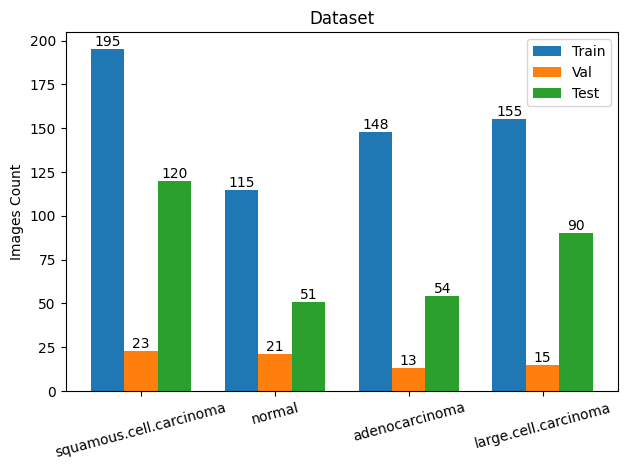

In [14]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Labels location and bars widht 
x = np.arange(len(labels))  
width = 0.25  

# Create plot and 3 sets of bars (train, val, test)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add labels, title, legend, count values...
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

# Optimized layout and displaying plot
fig.tight_layout()
plt.show()

In [16]:

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

# Using data generator to create augmented data from image files in train_path directory
train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data

Found 613 images belonging to 4 classes.


In [17]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [18]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
val_data.class_indices

Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [19]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

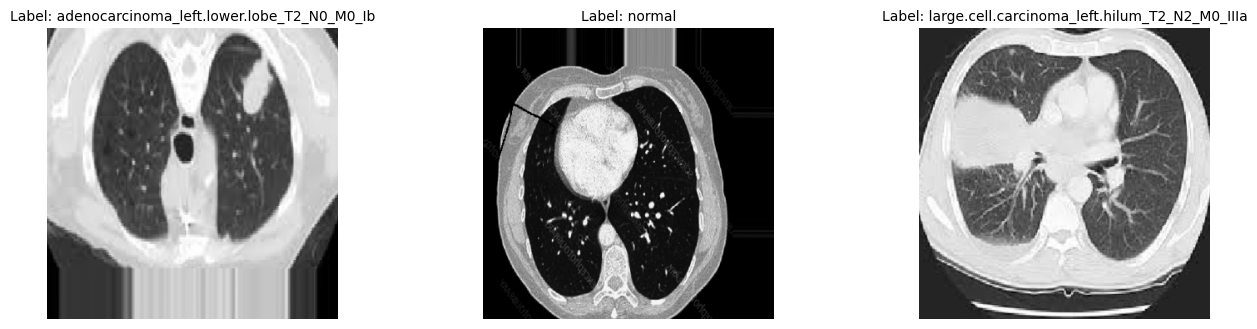

In [20]:
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))  
    fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

# Sample and plotting of 3 images with their respective labels from train_data
sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

In [21]:
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(350,350,3)
)

In [22]:
# We define the number of classes in the classification problem.
NUM_CLASSES = 4

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the 
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())

# A Dropout layer is added with a dropout rate of 25%. Dropout is used to prevent overfitting 
# by randomly disconnecting some neurons during training.
vgg_model.add(layers.Dropout(0.25))

# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function. 
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# The first layer of the model (base_model) is frozen, so the weights of this layer 
# will not be updated during training.
vgg_model.layers[0].trainable = False

# The model is compiled with the 'categorical_crossentropy' loss function,
#' adam' optimizer, and the accuracy metric. This prepares the model for training.
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [30]:
# Define the ModelCheckpoint callback with .keras extension
mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
call_back = [ mc];

In [31]:
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 35, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/35
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3924 - loss: 3.3327
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 777s 6s/step - accuracy: 0.3928 - loss: 3.3292 - val_accuracy: 0.4000 - val_loss: 3.6418
Epoch 2/35
  1/122 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - accuracy: 0.6000 - loss: 3.0502
Epoch 2: val_accuracy did not improve from 0.40000
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6000 - loss: 3.0502 - val_accuracy: 0.0000e+00 - val_loss: 5.8429
Epoch 3/35
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5956 - loss: 1.7967
Epoch 3: val_accuracy improved from 0.40000 to 0.50000, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.5955 - loss: 1.7958 - val_accuracy: 0.5000 - val_loss: 1.9732
Epoch 4/35
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.4000 - loss: 3.1671
Epoch 4: val_accuracy did not improve from 0.50000
122/

In [33]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model = load_model("./ct_vgg_best_model.keras")

# Evaluate the model on the test data
accuracy_vgg = model.evaluate(test_data)[1] 
print(f"The accuracy of the model is = {accuracy_vgg*100} %")

loss_vgg = model.evaluate(test_data)[0] 
print(f"The loss of the model is = {loss_vgg}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7363 - loss: 0.8268
The accuracy of the model is = 75.87301731109619 %
63/63 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.7625 - loss: 0.8077
The loss of the model is = 0.8326781392097473


In [34]:
base_model = InceptionV3(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [35]:
for layer in base_model.layers:
    layer.trainable = False

In [36]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
x = layers.Dense(4, activation='sigmoid')(x)

# We put together the original InceptionV3 and our new custom parts 
model_incep = tf.keras.models.Model(base_model.input, x)

# Compile up the rules and tools for training your neural network. 
# The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback with .keras extension
mc = ModelCheckpoint(
    filepath="./ct_incep_best_model.keras",
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    mode='auto'
)

# List of callbacks to pass to the training
call_back = [mc]


In [40]:
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 35, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/35
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3728 - loss: 11.0344
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to ./ct_incep_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.3734 - loss: 10.9973 - val_accuracy: 0.6000 - val_loss: 1.9484
Epoch 2/35
  1/122 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.8000 - loss: 1.5728
Epoch 2: val_accuracy improved from 0.60000 to 1.00000, saving model to ./ct_incep_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8000 - loss: 1.5728 - val_accuracy: 1.0000 - val_loss: 0.0975
Epoch 3/35
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5422 - loss: 2.5372
Epoch 3: val_accuracy did not improve from 1.00000
122/122 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.5424 - loss: 2.5351 - val_accuracy: 0.4857 - val_loss: 2.8978
Epoch 4/35
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.4000 - loss: 4.1266
Epoch 4: val_accuracy did not improve from 1.00000


In [42]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Loading the Best Fit Model
model = load_model("./ct_incep_best_model.keras")

# Checking the Accuracy and Loss of the Model
accuracy_incep = model.evaluate(test_data)[1]
print(f"The accuracy of the model is = {accuracy_incep*100} %")

loss_incep = model.evaluate(test_data)[0]
print(f"The loss of the model is = {loss_incep}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 601ms/step - accuracy: 0.6299 - loss: 1.2469
The accuracy of the model is = 62.22222447395325 %
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 585ms/step - accuracy: 0.6211 - loss: 1.3125
The loss of the model is = 1.2956783771514893


In [43]:
base_model = EfficientNetB0(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# Define the ModelCheckpoint callback with .keras extension
mc = ModelCheckpoint(
    filepath="./ct_effnet_best_model.keras",
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    mode='auto'
)

# Define the TensorBoard callback
tensorboard = TensorBoard(log_dir='logs')

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=2,
    min_delta=0.001,
    mode='auto',
    verbose=1
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# List of callbacks to pass to the training
call_back = [mc, tensorboard, reduce_lr, early_stopping]


In [67]:
#Customize our base model
EffNetmodel = base_model.output
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)
# to provide overfitting problem
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

#Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [68]:
#We put together the original EfficientNetB0 and our new custom parts 
EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)

#Compile up the rules and tools for training your neural network. 
#The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [69]:

EffNetB0 = EffNetmodel.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 30, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = [tensorboard, mc, reduce_lr, early_stopping]
    )

Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5030 - loss: 1.0988
Epoch 1: val_accuracy improved from -inf to 0.05714, saving model to ./ct_effnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.5036 - loss: 1.0983 - val_accuracy: 0.0571 - val_loss: 2.2406 - learning_rate: 0.0010
Epoch 2/30
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.6000 - loss: 0.7933
Epoch 2: val_accuracy did not improve from 0.05714
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6000 - loss: 0.7933 - val_accuracy: 0.0000e+00 - val_loss: 3.0386 - learning_rate: 0.0010
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6877 - loss: 0.7362
Epoch 3: val_accuracy improved from 0.05714 to 0.28571, saving model to ./ct_effnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6877 - loss: 0.7364 - val_accuracy: 0.2857 - val_loss: 2.5653 - learning_rate: 0.0010
Epoch 4/30
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy:

In [73]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model saved with .keras extension
model_eff = load_model("./ct_effnet_best_model.keras")

# Define the test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Update target_size to match the model's expected input size
test_data = test_datagen.flow_from_directory(
    "D:\\Prayag Files\\TIET\\Extras\\hackathons\\analog\\Data\\test",
    target_size=(350, 350),  # Update this to the expected input size
    batch_size=32,
    class_mode='categorical'  # Change to 'categorical'
)

# Checking the Accuracy and Loss of the Model using the evaluate method
loss_effnet, accuracy_effnet = model_eff.evaluate(test_data)
print(f"The accuracy of the model is = {accuracy_effnet*100:.2f} %")
print(f"The loss of the model is = {loss_effnet:.4f}")


Found 315 images belonging to 4 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4186 - loss: 19220.3359
The accuracy of the model is = 38.10 %
The loss of the model is = 20657.6914


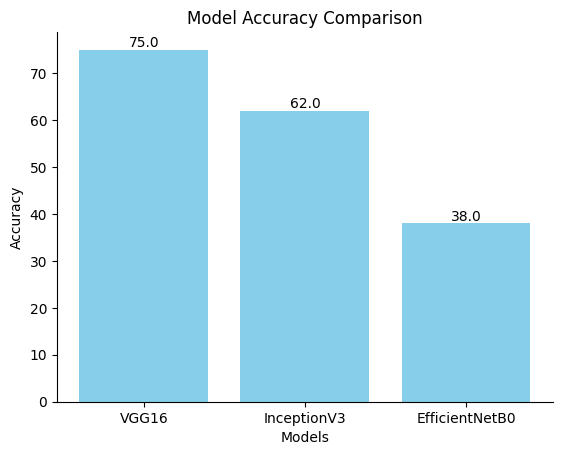

In [74]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
accuracy = [accuracy_vgg, accuracy_incep, accuracy_effnet]
accuracy = np.floor([i * 100 for i in accuracy])


fig, ax = plt.subplots()
bars = ax.bar(algos, accuracy, color='skyblue')

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

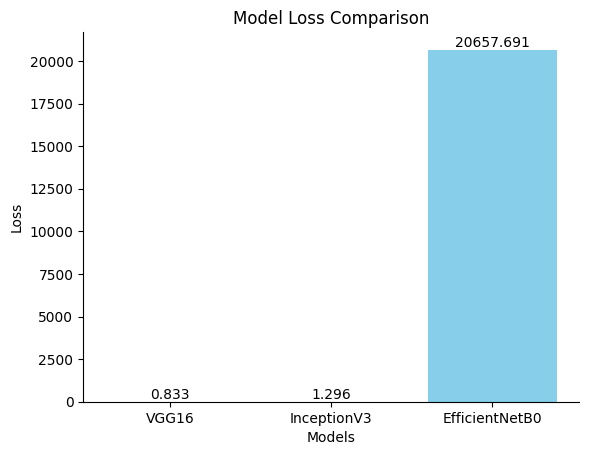

In [75]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
loss = [loss_vgg, loss_incep, loss_effnet]

fig, ax = plt.subplots()
bars = ax.bar(algos, loss, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

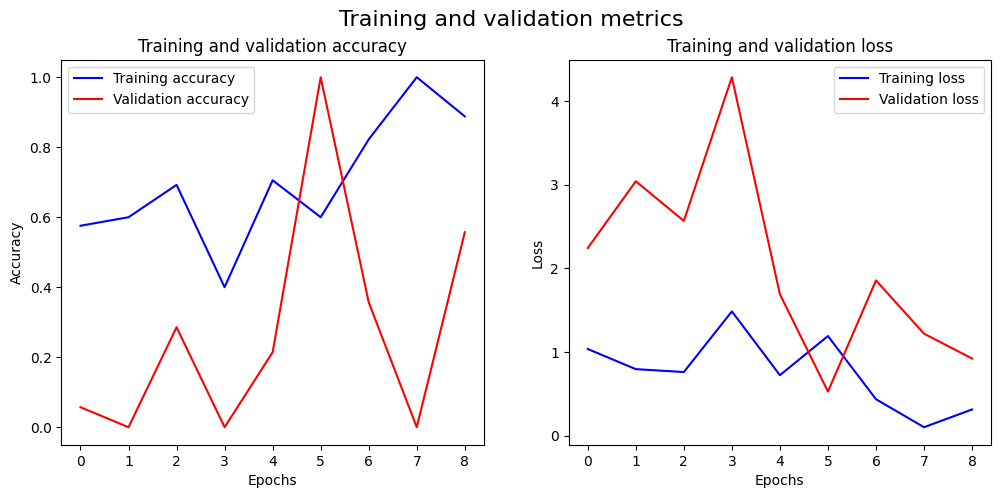

In [77]:

accuracy = EffNetB0.history['accuracy']
val_accuracy = EffNetB0.history['val_accuracy']

loss = EffNetB0.history['loss']
val_loss = EffNetB0.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Label: Adenocarcinoma
Actual Label: Adenocarcinoma


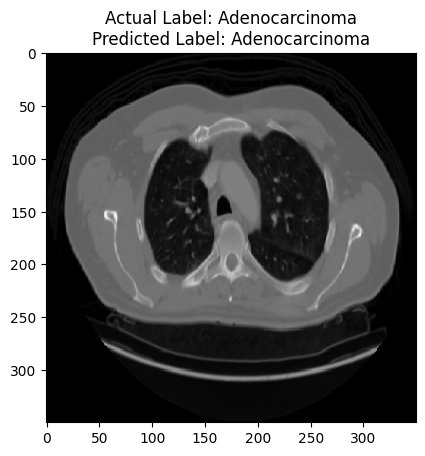

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Label: Adenocarcinoma
Actual Label: Adenocarcinoma


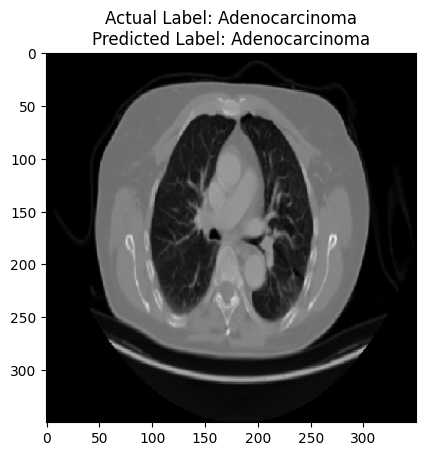

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Label: Adenocarcinoma
Actual Label: Squamous cell carcinoma


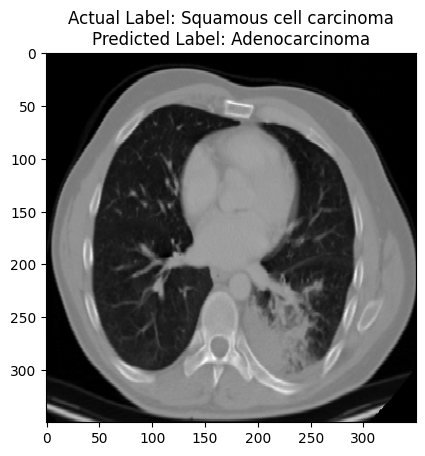

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Label: Adenocarcinoma
Actual Label: Squamous cell carcinoma


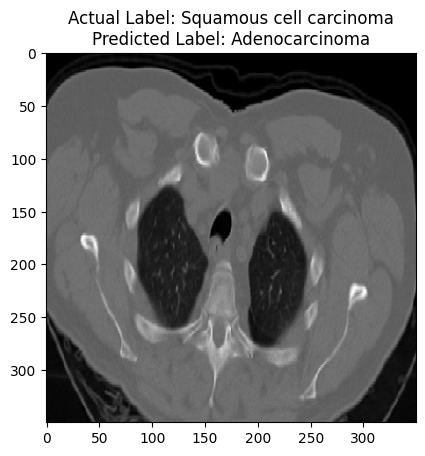

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def chestScanPrediction(paths, _model, actual_label):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    num_images = len(paths)
    
    for i in range(num_images):
        # Loading Image
        img = image.load_img(paths[i], target_size=(350, 350))

        # Normalizing Image
        norm_img = image.img_to_array(img) / 255.0

        # Converting Image to Numpy Array
        input_arr_img = np.expand_dims(norm_img, axis=0)

        # Getting Predictions
        pred = np.argmax(_model.predict(input_arr_img))

        # Printing Model Prediction and Actual Label
        print("Predicted Label:", classes_dir[pred])
        print("Actual Label:", classes_dir[actual_label[i]])
        
        # Displaying the image
        plt.imshow(img)
        plt.title("Actual Label: " + classes_dir[actual_label[i]] + "\nPredicted Label: " + classes_dir[pred])
        plt.show()

# Example usage:
paths = [
    r"D:\Prayag Files\TIET\Extras\hackathons\analog\Data\test\adenocarcinoma\000123 (6).png",
    r"D:\Prayag Files\TIET\Extras\hackathons\analog\Data\test\adenocarcinoma\000129.png",
    r"D:\Prayag Files\TIET\Extras\hackathons\analog\Data\valid\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa\000110 (6).png",
    r"D:\Prayag Files\TIET\Extras\hackathons\analog\Data\valid\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa\000114 (4).png"
]

actual_labels = [0, 0, 3, 3]  # Adjust actual labels based on your dataset

chestScanPrediction(paths, model_eff, actual_labels)
